In [1]:
import os
import sys
import pandas as pd
import numpy as np
#import random
#import tensorflow as tf

# For notebooks — get the current working directory
notebook_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(project_dir)

# Then import your module
#import Utils.functions as data_viz
import Utils.file_io as file_io

from dotenv import load_dotenv
load_dotenv()


False

In [2]:
#import re
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score, auc, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
#import tensorflow.keras.backend as K
import tensorflow as tf
from keras.metrics import AUC, Precision, Recall

2025-07-23 03:45:59.345733: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-23 03:45:59.630764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-23 03:45:59.753076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753242360.034492  234787 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753242360.105458  234787 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753242360.748398  234787 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
file_path = f"{project_dir}/Notebooks/Dataset/data_features"

df_features_daily = file_io.input_csv(f"{file_path}_daily")
df_features_weekly = file_io.input_csv(f"{file_path}_weekly")
df_features_monthly = file_io.input_csv(f"{file_path}_monthly")

#recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv")
#recessions = file_io.input_csv(f"{project_dir}/Dataset/recession_periods")
recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv1")

dict_features = {'Daily': df_features_daily,
                 'Weekly': df_features_weekly,
                 'Monthly': df_features_monthly
} 

train_test_split = pd.to_datetime('2015-01-01')
split_at = train_test_split

export_config = {'Print Out For all models': 
                  {'save': False},
                 'Save Probability Plots as PNG': 
                  {'save': False},
                 'Export AUC Report to CSV': 
                  {'save': False}
}

seed = 42
import random
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
#tf.config.experimental.enable_op_determinism()

DataFrame loaded from /workspaces/RecessionPredictionML/Notebooks/Dataset/data_features_daily.csv
DataFrame loaded from /workspaces/RecessionPredictionML/Notebooks/Dataset/data_features_weekly.csv
DataFrame loaded from /workspaces/RecessionPredictionML/Notebooks/Dataset/data_features_monthly.csv


In [4]:
# Refactor
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        
        cross_entropy = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)

        loss = alpha_factor * modulating_factor * cross_entropy
        return tf.reduce_mean(loss)
    
    return focal_loss

def make_sequences(X, y=None, seq_len=12):
    X_seq, y_seq, timestamps = [], [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X.iloc[i:i+seq_len].values)
        timestamps.append(X.index[i+seq_len])
        #print(timestamps)
        if y is not None:
            y_seq.append(y.iloc[i+seq_len])

    X_seq = np.array(X_seq)
    return (X_seq, np.array(y_seq)) if y is not None else (X_seq, None)


def get_class_weight(y_train):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    alpha = class_weights[1] / (class_weights[0] + class_weights[1])
    return class_weights_dict, alpha
    
    
def scaling_features(train,test, scaler_func = StandardScaler()):
    scaler = scaler_func
    X_train = train
    X_test = test
    n_train, seq_len, n_feat = X_train.shape
    n_test,      _   ,  _    = X_test.shape
    if scaler_func is None:
        return X_train, X_test, seq_len, n_feat

    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_feat)).reshape(n_train, seq_len, n_feat)
    X_test_scaled  = scaler.transform    (X_test.reshape(-1, n_feat)).reshape(n_test, seq_len, n_feat)

    return X_train_scaled, X_test_scaled, seq_len, n_feat, scaler



def layer_sizes(str_var):
    #str_var = 'LSTM_4_2'
    parts = str_var.split('_')
    int_list = [int(x) for x in parts[1:]]
    model_type = parts[0]
    return int_list, model_type
    

In [5]:
'''
def scaling_features1(train, test, scaler_func=StandardScaler()):
    # Helper function to check and extract info & reshape if input is a DataFrame
    def prepare_data(X):
        if isinstance(X, pd.DataFrame) and isinstance(X.index, pd.MultiIndex):
            # Extract unique sequences (level 0) and sequence length (level 1)
            seq_ids = X.index.get_level_values(0).unique()
            seq_len = X.index.get_level_values(1).nunique()
            n_feat = X.shape[1]
            
            # Convert DataFrame to numpy array of shape (n_seq, seq_len, n_feat)
            X_np = X.values.reshape(len(seq_ids), seq_len, n_feat)
            return X_np, seq_ids, seq_len, n_feat
        else:
            # Assume numpy array input
            n_seq, seq_len, n_feat = X.shape
            return X, None, seq_len, n_feat
    
    X_train_np, train_seq_ids, seq_len, n_feat = prepare_data(train)
    X_test_np, test_seq_ids, _, _ = prepare_data(test)

    if scaler_func is None:
        # Return input as is, but convert DataFrame to numpy if needed
        return X_train_np, X_test_np, seq_len, n_feat

    scaler = scaler_func
    n_train = X_train_np.shape[0]
    n_test = X_test_np.shape[0]

    # Flatten for scaler
    X_train_scaled = scaler.fit_transform(X_train_np.reshape(-1, n_feat)).reshape(n_train, seq_len, n_feat)
    X_test_scaled = scaler.transform(X_test_np.reshape(-1, n_feat)).reshape(n_test, seq_len, n_feat)

    # If original input was DataFrame, reconstruct scaled DataFrames with same MultiIndex and columns
    if train_seq_ids is not None:
        # Rebuild MultiIndex for train
        train_index = pd.MultiIndex.from_product([train_seq_ids, range(seq_len)], names=['sequence', 'step'])
        X_train_scaled = pd.DataFrame(X_train_scaled.reshape(-1, n_feat), index=train_index, columns=train.columns)

        # Rebuild MultiIndex for test
        test_index = pd.MultiIndex.from_product([test_seq_ids, range(seq_len)], names=['sequence', 'step'])
        X_test_scaled = pd.DataFrame(X_test_scaled.reshape(-1, n_feat), index=test_index, columns=test.columns)

    return X_train_scaled, X_test_scaled, seq_len, n_feat

def make_sequences1(X: pd.DataFrame, y: pd.Series = None, seq_len: int = 12):
    X_seq_list, y_seq_list, timestamps = [], [], []

    for i in range(len(X) - seq_len):
        seq_df = X.iloc[i:i+seq_len]
        X_seq_list.append(seq_df)
        timestamps.append(X.index[i + seq_len])
        if y is not None:
            y_seq_list.append(y.iloc[i + seq_len])

    # Combine all sequences into a MultiIndex DataFrame
    X_seq = pd.concat(X_seq_list, keys=timestamps, names=["timestamp", "step"])
    
    if y is not None:
        y_seq = pd.Series(y_seq_list, index=timestamps, name='target')
        return X_seq, y_seq
    else:
        return X_seq, None
'''

'\ndef scaling_features1(train, test, scaler_func=StandardScaler()):\n    # Helper function to check and extract info & reshape if input is a DataFrame\n    def prepare_data(X):\n        if isinstance(X, pd.DataFrame) and isinstance(X.index, pd.MultiIndex):\n            # Extract unique sequences (level 0) and sequence length (level 1)\n            seq_ids = X.index.get_level_values(0).unique()\n            seq_len = X.index.get_level_values(1).nunique()\n            n_feat = X.shape[1]\n\n            # Convert DataFrame to numpy array of shape (n_seq, seq_len, n_feat)\n            X_np = X.values.reshape(len(seq_ids), seq_len, n_feat)\n            return X_np, seq_ids, seq_len, n_feat\n        else:\n            # Assume numpy array input\n            n_seq, seq_len, n_feat = X.shape\n            return X, None, seq_len, n_feat\n\n    X_train_np, train_seq_ids, seq_len, n_feat = prepare_data(train)\n    X_test_np, test_seq_ids, _, _ = prepare_data(test)\n\n    if scaler_func is None:\

In [6]:


#X_train_scaled, X_test_scaled, seq_len, n_feat = scaling_features(X_train, X_test) #one time calculation per time_freq?

#class_weights_dict, alpha = compute_class_weight(y_train) # one time calculation per time_freq?

def LSTM_Model_init(model_name, seq_len, n_feat, alpha):

    layer_size, model_type = layer_sizes(model_name)

    is_bi = model_type.upper().startswith("BILSTM")

    #Build model
    model = Sequential()
    model.add(Input(shape=(seq_len, n_feat)))
    

    for i, units in enumerate(layer_size):
        return_seq = (i < len(layer_size) - 1)
        lstm_layer = LSTM(units, return_sequences=return_seq)

        if is_bi:
            # wrap in Bidirectional
            model.add(Bidirectional(lstm_layer))
        else:
            model.add(lstm_layer)
        
        model.add(Dropout(0.3))
    # stuff
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss=binary_focal_loss(gamma=2.0, alpha=alpha),
        #metrics=["accuracy"]
        metrics=[#"Precision", "Recall", #"AUC"]
                    AUC(name='AUC-ROC', curve = 'ROC'),
                    AUC(name='AUC-PR', curve='PR')]
    )

    return model

#early_stop = EarlyStopping(monitor="val_Recall", patience=10, restore_best_weights=True, mode='max')

def LSTM_Model_train(train, test, early_stop, model, class_weights, verbose = 0):
    X_train_scaled, y_train = train[0], train[1]
    X_test_scaled, y_test = test[0], test[1]
    callback_list = [early_stop] if early_stop is not None else []
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50, batch_size=32,
        callbacks=callback_list,
        class_weight=class_weights,
        verbose=verbose#, shuffle = False
    )

    #X_all_scaled = np.concatenate([X_train_scaled, X_test_scaled], axis=0) #pd.concat([X_train_scaled, X_test_scaled])
    #probs_all = model.predict(X_all_scaled, verbose=verbose).reshape(-1)
    epochs = len(history.history['loss'])

    probs = model.predict(X_test_scaled, verbose=verbose).reshape(-1)
    probs_all = probs
    return model, epochs, probs_all

def LSTM_Model_evaluate(test, probs, threshold = None):
    X_test_scaled, y_test = test[0], test[1]
    if threshold is None:
        threshold = 0.001
    y_pred = (probs >= threshold).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    #cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["No Recession", "Recession"], output_dict=True, zero_division=0)
    report["auc_pr"] = auc(recall, precision)
    ap_score = average_precision_score(y_test, probs)
    report["ap_score"]=  ap_score
    report["ap_score_inverted"] = 1-ap_score
    report["auc_roc"]= roc_auc_score(y_test, probs)

    #epochs = len(history.history['loss'])
    return report




In [7]:
LSTM_models = ['LSTM_4_2', 'LSTM_4_4']
LSTM_results = {}
early_stop = EarlyStopping(monitor="val_AUC-ROC", patience=10, restore_best_weights=True, mode='max')

In [8]:
'''time_freq = 'Monthly'
model_name = LSTM_models[0]
df = dict_features[time_freq]
X = df.drop(columns='recession')
y = df['recession'] 

# Train-test split
#split_at = pd.to_datetime('2015-01-01')
X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
y_train, y_test = y[y.index < split_at].astype(int), y[y.index >= split_at].astype(int)
# Convert to sequences
seq_len = 32
X_train_seq, y_train_seq = make_sequences(X_train, y_train, seq_len)
X_test_seq, y_test_seq = make_sequences(X_test, y_test, seq_len)
X_train_scaled, X_test_scaled, _, n_feat = scaling_features(X_train_seq, X_test_seq) 
class_weights_dict, alpha = get_class_weight(y_train_seq) 
LSTM_results[time_freq] = {}
LSTM_results[time_freq][model_name] = {}
print(model_name)
model_init = LSTM_Model_init(model_name, seq_len, n_feat, alpha)
print('Done with Init')
model, epoch, probs = LSTM_Model_train(train = [X_train_scaled,y_train_seq], test = [X_test_scaled, y_test_seq], 
                 model = model_init, early_stop = early_stop, class_weights = class_weights_dict, 
                 verbose = 0)
print('Done with training')

report = LSTM_Model_evaluate(test = [_, y_test_seq], probs = probs, threshold = None)  
        
#LSTM_results[time_freq][model_name]['probs'] = probs
LSTM_results[time_freq][model_name]['report'] = report
LSTM_results[time_freq][model_name]['epoch'] = epoch
LSTM_results[time_freq][model_name]['model'] = model

print(LSTM_results[time_freq][model_name]['report'])

period = time_freq


print(f"\n=== {time_freq} | {model_name} ===")
#print("Confusion Matrix:\n", LSTM_results[time_freq][f'{model_name}_confusion_matrix'])
print("Classification Report:")
print(pd.DataFrame(LSTM_results[time_freq][model_name]['report']).transpose())
'''

'time_freq = \'Monthly\'\nmodel_name = LSTM_models[0]\ndf = dict_features[time_freq]\nX = df.drop(columns=\'recession\')\ny = df[\'recession\'] \n\n# Train-test split\n#split_at = pd.to_datetime(\'2015-01-01\')\nX_train, X_test = X[X.index < split_at], X[X.index >= split_at]\ny_train, y_test = y[y.index < split_at].astype(int), y[y.index >= split_at].astype(int)\n# Convert to sequences\nseq_len = 32\nX_train_seq, y_train_seq = make_sequences(X_train, y_train, seq_len)\nX_test_seq, y_test_seq = make_sequences(X_test, y_test, seq_len)\nX_train_scaled, X_test_scaled, _, n_feat = scaling_features(X_train_seq, X_test_seq) \nclass_weights_dict, alpha = get_class_weight(y_train_seq) \nLSTM_results[time_freq] = {}\nLSTM_results[time_freq][model_name] = {}\nprint(model_name)\nmodel_init = LSTM_Model_init(model_name, seq_len, n_feat, alpha)\nprint(\'Done with Init\')\nmodel, epoch, probs = LSTM_Model_train(train = [X_train_scaled,y_train_seq], test = [X_test_scaled, y_test_seq], \n              

In [9]:
for time_freq, df in dict_features.items():
    X = df.drop(columns='recession')
    y = df['recession'] 

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    y_train, y_test = y[y.index < split_at].astype(int), y[y.index >= split_at].astype(int)

    # Convert to sequences
    seq_len = 32
    X_train_seq, y_train_seq = make_sequences(X_train, y_train, seq_len)
    X_test_seq, y_test_seq = make_sequences(X_test, y_test, seq_len)

    X_train_scaled, X_test_scaled, _, n_feat, scaler = scaling_features(X_train_seq, X_test_seq) #one time calculation per time_freq?
    class_weights_dict, alpha = get_class_weight(y_train_seq) # one time calculation per time_freq?

    LSTM_results[time_freq] = {}
    for model_name in LSTM_models:
        LSTM_results[time_freq][model_name] = {}
        #print(model_name)
        #tf.keras.utils.set_random_seed(seed)
        model_init = LSTM_Model_init(model_name, seq_len, n_feat, alpha)
        print('Done with Init')
        model, epoch, probs = LSTM_Model_train(train = [X_train_scaled,y_train_seq], test = [X_test_scaled, y_test_seq], 
                         model = model_init, early_stop = early_stop, class_weights = class_weights_dict, 
                         verbose = 0)
        print(f'Done with training {model_name} with {epoch} epochs on {time_freq} data')
        report = LSTM_Model_evaluate(test = [_, y_test_seq], probs = probs, threshold = 0.5)  
        
        #LSTM_results[time_freq][model_name]['probs'] = probs_all
        LSTM_results[time_freq][model_name]['scaler'] = scaler
        LSTM_results[time_freq][model_name]['report'] = report
        LSTM_results[time_freq][model_name]['epoch'] = epoch
        LSTM_results[time_freq][model_name]['model'] = model




2025-07-23 03:46:05.737112: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Done with Init


Done with training LSTM_4_2 with 11 epochs on Daily data
Done with Init
Done with training LSTM_4_4 with 11 epochs on Daily data
Done with Init
Done with training LSTM_4_2 with 11 epochs on Weekly data
Done with Init
Done with training LSTM_4_4 with 34 epochs on Weekly data
Done with Init
Done with training LSTM_4_2 with 50 epochs on Monthly data
Done with Init
Done with training LSTM_4_4 with 50 epochs on Monthly data


In [10]:
if True:#export_config['Print Out For all models']['save']:
    for time_freq in LSTM_results.keys():
        for model_name in LSTM_results[time_freq].keys():
            print(f"\n=== {time_freq} | {model_name} ===")
            #print("Confusion Matrix:\n", LSTM_results[time_freq][f'{model_name}_confusion_matrix'])
            print("Classification Report:")
            print(pd.DataFrame(LSTM_results[time_freq][model_name]['report']).transpose())


=== Daily | LSTM_4_2 ===
Classification Report:
                   precision    recall  f1-score      support
No Recession        1.000000  0.065601  0.123124  2439.000000
Recession           0.122111  1.000000  0.217645   317.000000
accuracy            0.173077  0.173077  0.173077     0.173077
macro avg           0.561055  0.532800  0.170385  2756.000000
weighted avg        0.899024  0.173077  0.133996  2756.000000
auc_pr              0.373894  0.373894  0.373894     0.373894
ap_score            0.375022  0.375022  0.375022     0.375022
ap_score_inverted   0.624978  0.624978  0.624978     0.624978
auc_roc             0.871477  0.871477  0.871477     0.871477

=== Daily | LSTM_4_4 ===
Classification Report:
                   precision    recall  f1-score      support
No Recession        1.000000  0.173842  0.296193  2439.000000
Recession           0.135935  1.000000  0.239336   317.000000
accuracy            0.268868  0.268868  0.268868     0.268868
macro avg           0.567967  0.58

In [11]:
var = LSTM_results['Daily']#['LSTM_4_4']#['epoch']
print(var)
print(len(var))

for key in var.keys():
    print(key)

{'LSTM_4_2': {'scaler': StandardScaler(), 'report': {'No Recession': {'precision': 1.0, 'recall': 0.06560065600656007, 'f1-score': 0.12312427856868026, 'support': 2439.0}, 'Recession': {'precision': 0.12211093990755008, 'recall': 1.0, 'f1-score': 0.21764503947820116, 'support': 317.0}, 'accuracy': 0.17307692307692307, 'macro avg': {'precision': 0.5610554699537751, 'recall': 0.53280032800328, 'f1-score': 0.17038465902344072, 'support': 2756.0}, 'weighted avg': {'precision': 0.8990236458456797, 'recall': 0.17307692307692307, 'f1-score': 0.13399622385471732, 'support': 2756.0}, 'auc_pr': np.float64(0.37389407521067763), 'ap_score': np.float64(0.3750216388446276), 'ap_score_inverted': np.float64(0.6249783611553724), 'auc_roc': np.float64(0.8714766485204286)}, 'epoch': 11, 'model': <Sequential name=sequential, built=True>}, 'LSTM_4_4': {'scaler': StandardScaler(), 'report': {'No Recession': {'precision': 1.0, 'recall': 0.17384173841738418, 'f1-score': 0.29619280475026194, 'support': 2439.0}

In [12]:
import matplotlib.pyplot as plt

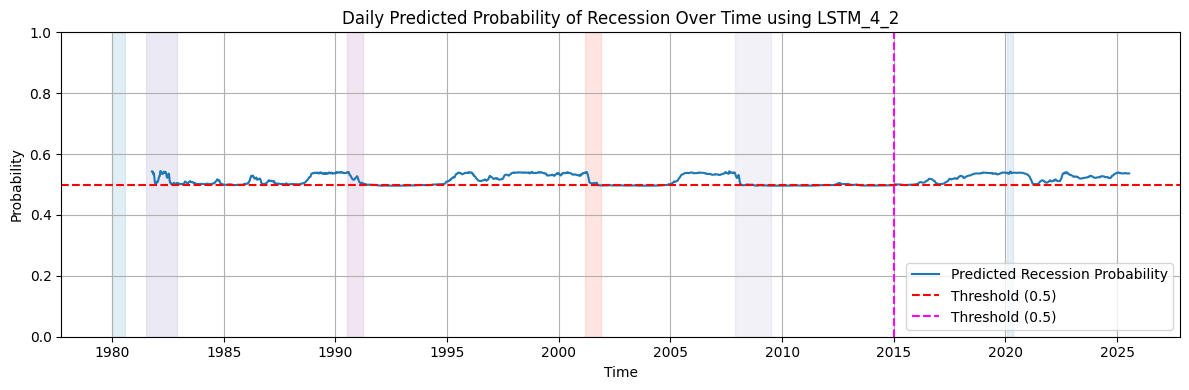

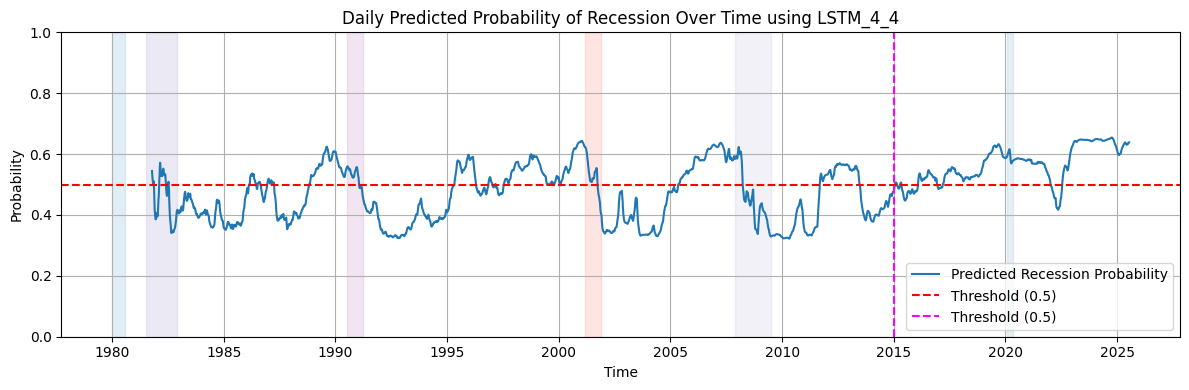

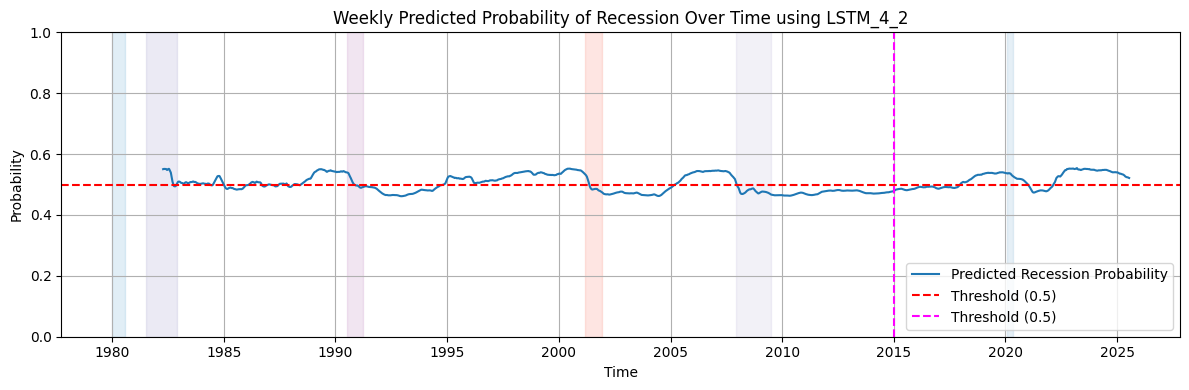

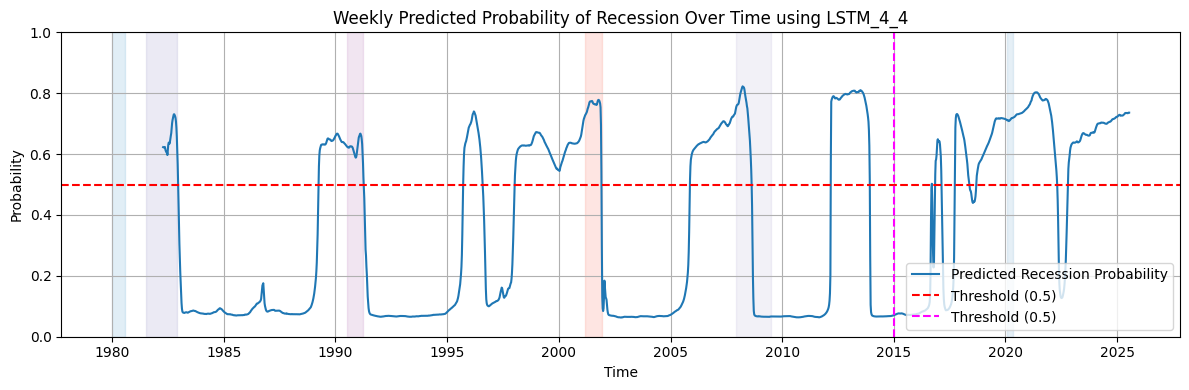

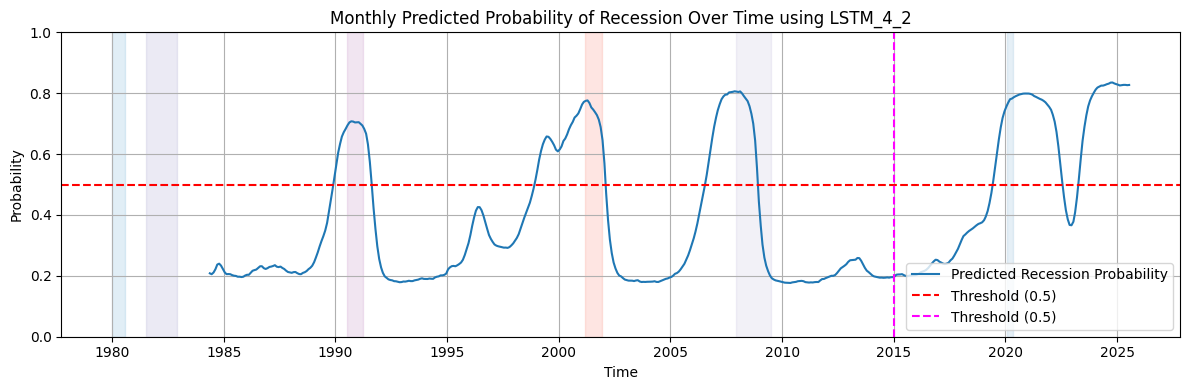

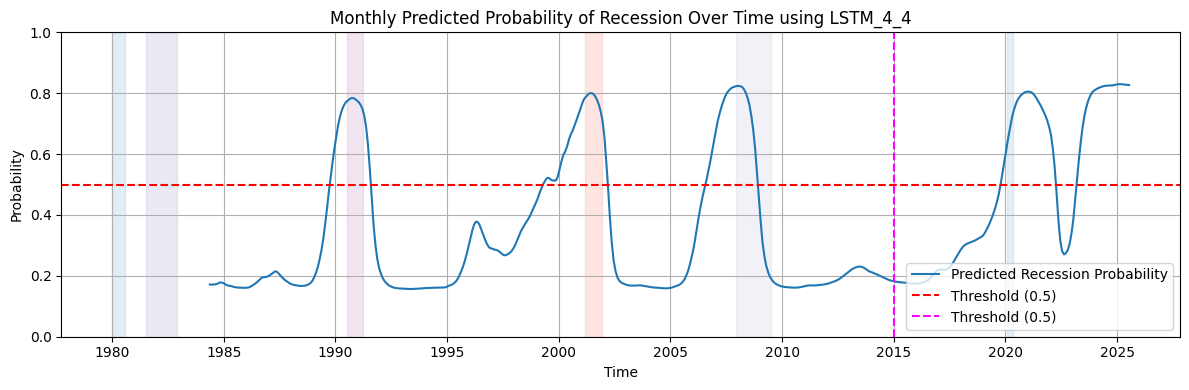

In [13]:
for time_freq, df in dict_features.items():
    X = df.drop(columns='recession')
    y = df['recession']

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    #X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    #y_train, y_test = y[y.index < split_at].astype(int), y[y.index >= split_at].astype(int)
    X_all = X
    
    for model_name in LSTM_models:
        model = LSTM_results[time_freq][model_name]['model']
        scaler = LSTM_results[time_freq][model_name]['scaler']
        
        X_all_seq, _ = make_sequences(X_all, y=None, seq_len=seq_len)
        X_all_scaled = scaler.transform(X_all_seq.reshape(-1, X_all.shape[1])).reshape(X_all_seq.shape)

        probs_all = model.predict(X_all_scaled, verbose=0)
        dates_all = X_all.index[seq_len:]
        prob_series = pd.Series(probs_all.flatten(), index=dates_all)

        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(prob_series, label='Predicted Recession Probability')
        ax.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
        split_at = train_test_split
        ax.axvline(x=split_at, color='magenta', linestyle='--', label='Threshold (0.5)')

        if recessions is not None:
            for row in recessions.itertuples(index=False):
                plt.axvspan(pd.to_datetime(row.start), pd.to_datetime(row.end), color=row.color, alpha=0.2)

        ax.set_title(f'{time_freq} Predicted Probability of Recession Over Time using {model_name}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Probability')
        ax.set_ylim(0, 1)
        ax.legend(loc='lower right')
        ax.grid(True)
        plt.tight_layout()
        plt.show()


